#  Description
The online store is planning to launch a new service so that users can edit and supplement product descriptions, offer their edits and comment on the edits of other buyers. The store needs a tool that will search for toxic comments and send them for moderation.

# Task
Speed up the moderation of comments in the community by automating the assessment of their toxicity.  
Train the model to classify comments into positive and negative. At your disposal is a data set with markup on the toxicity of edits.  
Build a model with the value of the quality metric **F1** at least 0.75.  




# Описание
Интернет-магазин планирует запускает новый сервис, чтобы пользователи могли редактировать и дополнять описания товаров, предлагать свои правки и комментировать правки других покупателей. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

# Задача
Ускорить модерацию комментариев в сообществе, автоматизировав оценку их токсичности.
Обучить модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.
Постройте модель со значением метрики качества **F1** не меньше 0.75. 


__Content__


1. [Explore and prepare data](#1)
 - [Processing comment texts](#11)
 - [Word Frequency in Comments](#12)
2. [Training](#2)
 - [Prepare for training](#2)
 - [Getting samples](#22)
 - [LogisticRegression](#13)
 - [RandomForestClassifier](#14)
 - [KNeighborsClassifier](#15)
 - [LGBMClassifier](#16)
 - [LogisticRegression (ngram_range = 2)](#17)
3. [Test](#3)
4. [Conclusions](#4)

__Содержание__


1. [Изучение и подготовка данных](#1)

 - [Обработка текстов комментариев](#11)
 - [Частота слов в комментариях](#12)
2. [Обучение](#2)
 - [Подготовка к обучению](#2)
 - [Получение выборок](#22)
 - [LogisticRegression](#13)
 - [RandomForestClassifier](#14)
 - [KNeighborsClassifier](#15)
 - [LGBMClassifier](#16)
 - [LogisticRegression (ngram_range = 2)](#17)
3. [Проверка на тесте](#3)
4. [Выводы](#4)

In [1]:
import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import warnings

warnings.filterwarnings("ignore")
import re
import string
from collections import Counter

import lightgbm as lgb
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    plot_confusion_matrix,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
from nltk.corpus import stopwords

nltk.download("stopwords")
from nltk.corpus import wordnet

nltk.download("wordnet")
import torch
import transformers
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm import notebook, tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<a id='1'></a>

# 1. Explore and prepare data / Подготовка

### Первичное ознакомление

In [2]:
data = pd.read_csv("/app/_data/toxic_comments.csv")

In [3]:
data.head()
data.info()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In the table 159571 row, 2 columns - the text of the comment and the assessment of its toxicity. Comments in English. There are no missing values.
Checking for duplicates:  
В таблице 159571 строка, 2 столбца - текст комментария и оценка его токсичности. Комментарии на английском. Пропусков нет.    
Проверяем дубликаты:

In [4]:
data.duplicated().sum()

0

There are no duplicates. Let's look at the ratio of toxic and normal comments.  
Дубликатов нет. Посмотрим соотношение токсичных и нормальных комментариев.

Ratio of toxic and normal comments
Соотношение токсичных и нормальных комментариев
 0    0.898321
1    0.101679
Name: toxic, dtype: float64 



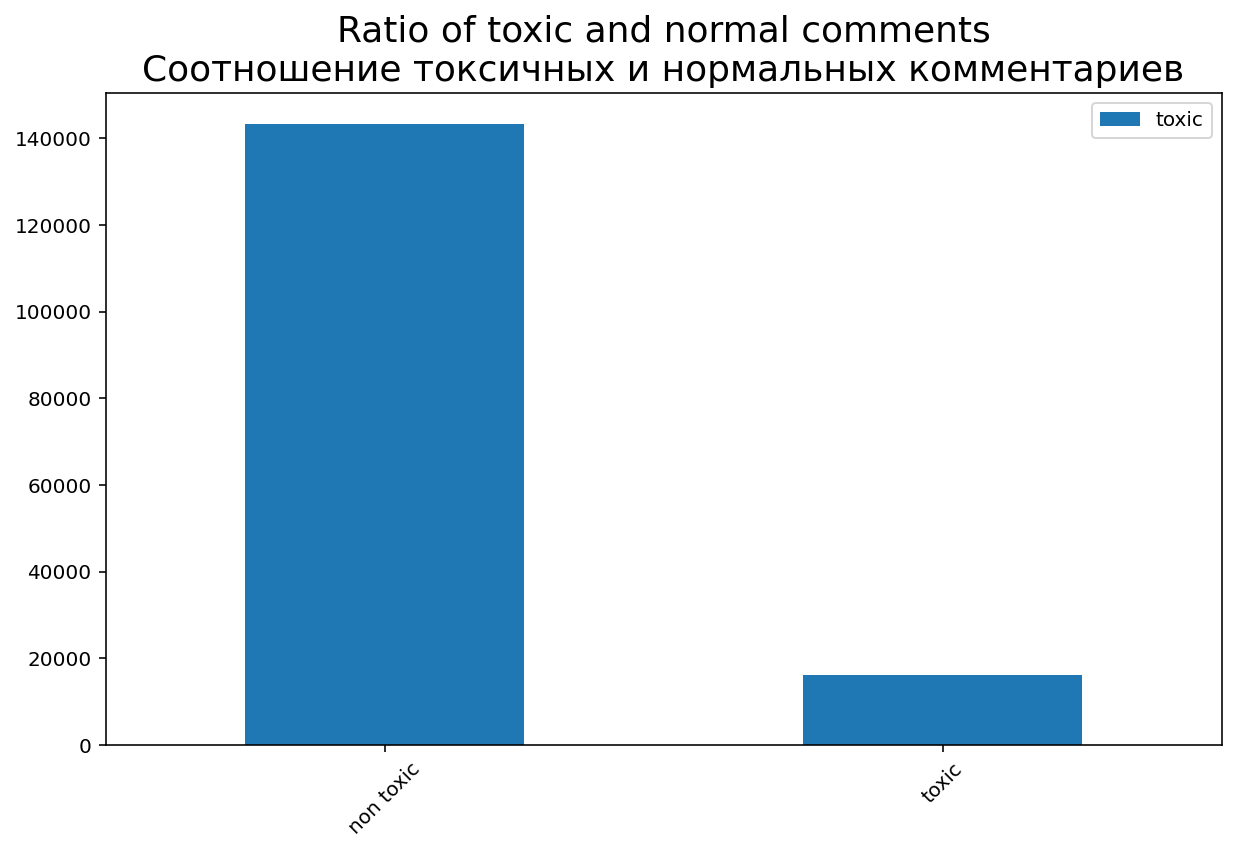

In [5]:
print(
    "Ratio of toxic and normal comments\nСоотношение токсичных и нормальных комментариев\n",
    data.toxic.value_counts(normalize=True),
    "\n",
)
data.toxic.value_counts().plot(kind="bar", figsize=(10, 6))
plt.title(
    "Ratio of toxic and normal comments\nСоотношение токсичных и нормальных комментариев",
    fontsize=18,
)
plt.xticks(
    ticks=data.toxic.value_counts(normalize=True).index,
    labels=["non toxic", "toxic"],
    rotation=45,
)
plt.legend()
plt.show();

Most of the comments are normal (89.8%), and 10.2% are toxic. That is, we have a dataset with an imbalanced data.
Let's see if there are differences in these comments in terms of the length of the comments, the number of words, and punctuation marks.  

Большая часть комментариев - нормальные (89,8%), токсичных - 10,2%. То есть у нас датасет с дисбалансом данных.  
Посмотрим, есть ли различия в этих комментариях с точки зрения длины комментариев, количества слов и знаков препинания.

In [6]:
data["len_text"] = data["text"].apply(len)
data["word_count"] = data["text"].apply(lambda x: len(str(x).split()))
data["punctuation"] = data["text"].apply(
    lambda x: len([c for c in str(x) if c in string.punctuation])
)

In [7]:
print("Length of comments\nДлина комментариев\n")
data.groupby("toxic")["len_text"].describe()
print("Number of punctuation marks\nКоличество знаков препинания\n")
data.groupby("toxic")["punctuation"].describe()
print("Number of words\nКоличество слов\n")
data.groupby("toxic").word_count.describe()

Length of comments
Длина комментариев



,count,mean,std,min,25%,50%,75%,max
toxic,,,,,,,,
0,143346.0,404.347174,586.503447,6.0,102.0,216.0,452.0,5000.0
1,16225.0,303.304037,619.402896,8.0,61.0,128.0,283.0,5000.0


Number of punctuation marks
Количество знаков препинания



,count,mean,std,min,25%,50%,75%,max
toxic,,,,,,,,
0,143346.0,16.033583,26.832999,0.0,4.0,9.0,18.0,2762.0
1,16225.0,14.576394,82.749890,0.0,2.0,5.0,12.0,4942.0


Number of words
Количество слов



,count,mean,std,min,25%,50%,75%,max
toxic,,,,,,,,
0,143346.0,68.921065,98.195083,1.0,18.0,38.0,78.0,1250.0
1,16225.0,52.717720,106.854731,2.0,11.0,23.0,50.0,1411.0


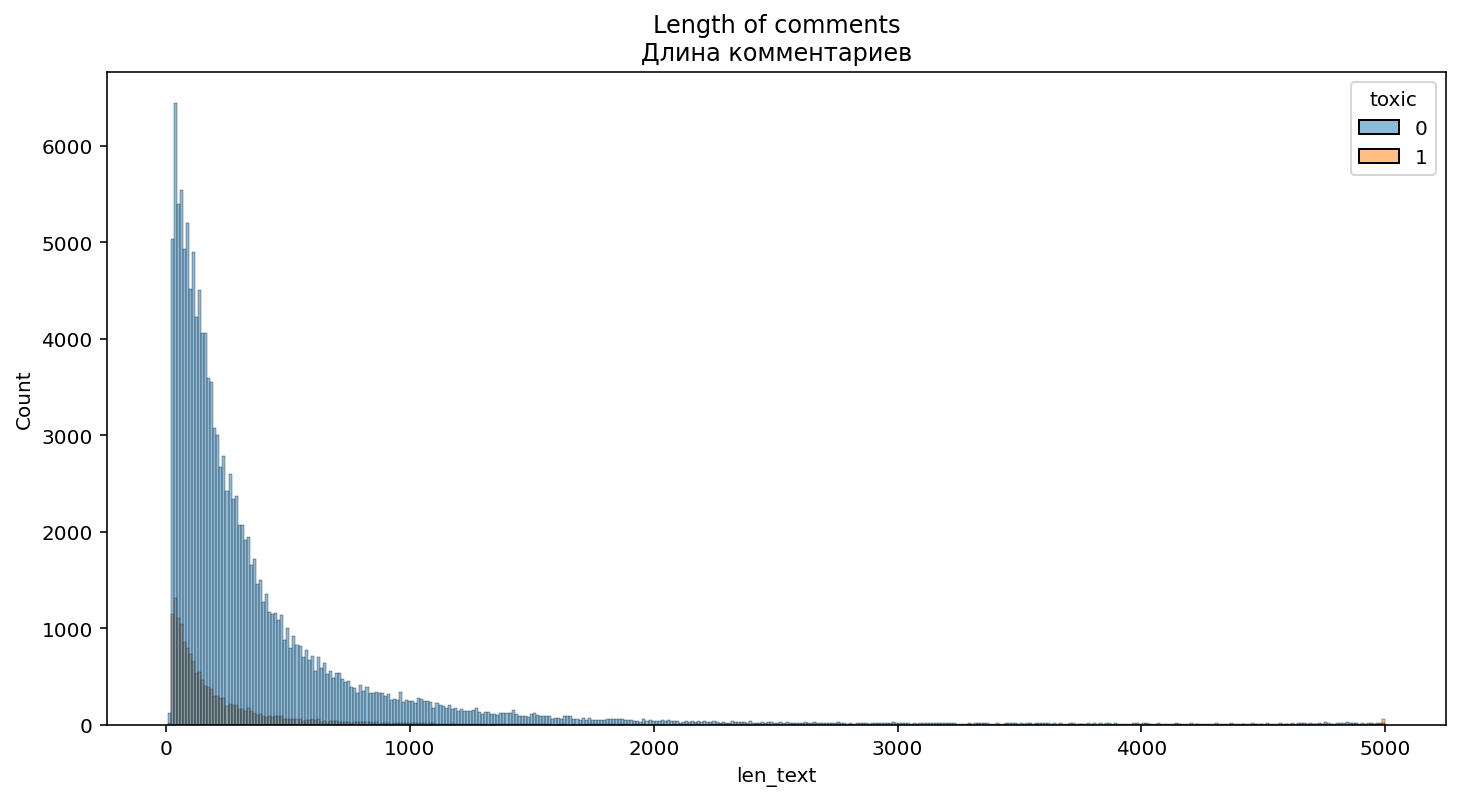

In [8]:
plt.figure(figsize=(12, 6))
plot = sns.histplot(data, x="len_text", hue="toxic")
plot.set(title="Length of comments\nДлина комментариев")
plt.show();

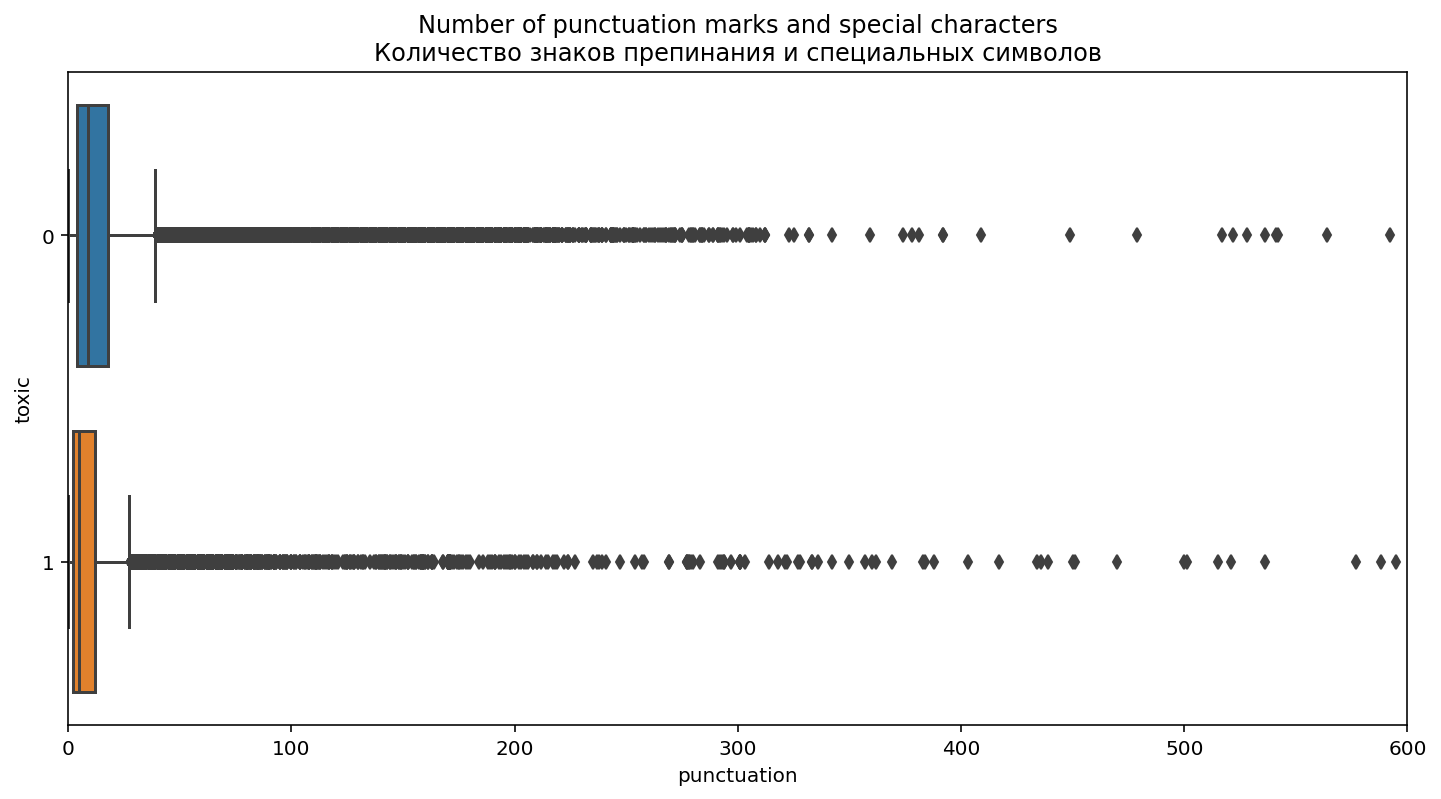

In [9]:
plt.figure(figsize=(12, 6))
plot = sns.boxplot(data=data, x="punctuation", y="toxic", orient="h")
plt.xlim(0, 600)
plot.set(
    title="Number of punctuation marks and special characters\nКоличество знаков препинания и специальных символов"
)
plt.show();

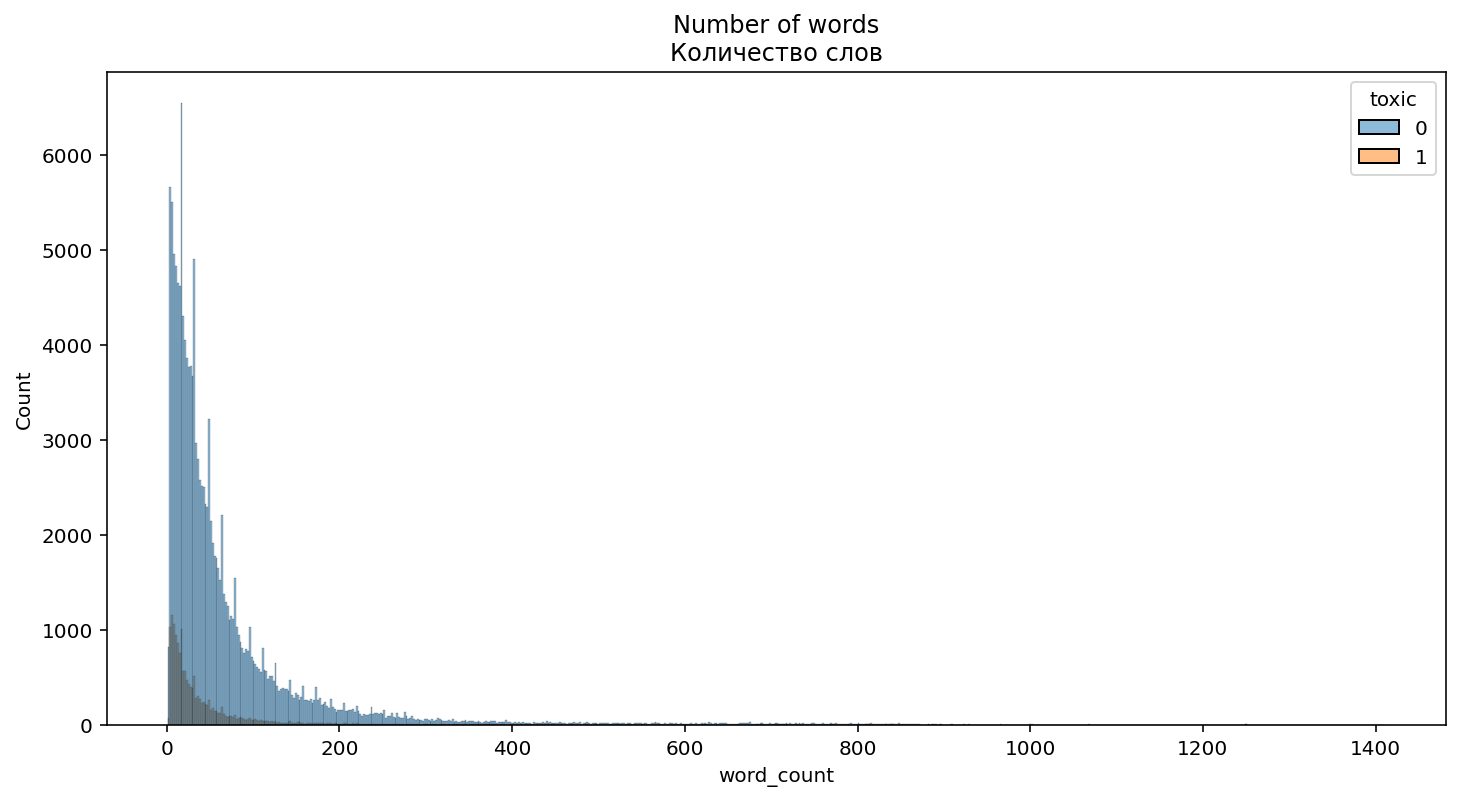

In [10]:
plt.figure(figsize=(12, 6))
plot = sns.histplot(data, x="word_count", hue="toxic")
plot.set(title="Number of words\nКоличество слов")
plt.show();

On average, toxic comments are shorter and have fewer words than normal ones, but they have a larger range of meanings. The minimum length of comments in the dataset is 6 characters, 1 word, and the maximum size is 5000 characters, 1411 words. Punctuation marks in toxic comments are also slightly less on average.

Before analyzing and building models, we need to process comments, remove unnecessary characters, and lemmatize them. Since the language of comments is English, I use the nltk library.  

В среднем токсичные комментарии короче и с меньшим количеством слов, чем нормальные, но разброс значений у них больше.  Минимальная длина комментариев в датасете - 6 символов, 1 слово, максимальный размер - 5000 символов, 1411 слов.  Знаков препинания в токсичных комментариях тоже в среднем чуть меньше.   

Перед тем, как анализировать и строить модели, комментарии надо обработать, удалить лишние символы, лемматизировать. Поскольку язык комментариев - английский, использую библиотеку nltk.

<a id='11'></a>

## Processing of comment texts / Обработка текстов комментариев

A function that performs automatic morphological markup of words for correct lemmatization  
Функция, которая проводит автоматическую морфологическую разметку слов для корректной лемматизации

In [11]:
wnl = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))


def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV,
    }

    return tag_dict.get(tag, wordnet.NOUN)

___prepare_texts___
- removes links,
- removes whitespace, line breaks, etc.,
- translates texts to lowercase,
- leaves only letters,
- lemmatizes,
- removes stop words,
- outputs cleaned string.  

___prepare_texts___
 - удаляет ссылки,
 - удаляет пробельные символы, переносы строк и тп,
 - переводит тексты к нижнему регистру,
 - оставляет только буквы,
 - лемматизирует,
 - удаляет стоп-слова,
 - выдает склеенную очищенную строку.

In [12]:
def prepare_texts(text):
    text = re.sub(r"http://\S+|www\.\S+|[\s]|[^a-z]", " ", text.lower())
    text = re.sub(r"\s.{1,2}\b|\b.{1,2}\s|\s.{1, 2}\s", " ", text)
    set_words = [wnl.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
    final_text = " ".join([w for w in set_words if not w in stop_words])
    return final_text

Since it takes a lot of time to process the entire dataset, I will use the example of 500 lines to show that the function works, and I will load the full prepared dataset separately.  

Поскольку на обработку всего датасета уходит много времени, то на примере в 500 строк покажу, что функция работает, а полный подготовленный датасет загружу отдельно.

In [13]:
df_500 = data.sample(500).reset_index(drop=True)

In [14]:
df_500["clean_text"] = df_500["text"].apply(prepare_texts)

In [15]:
df_500.head(2)

,text,toxic,len_text,word_count,punctuation,clean_text
0,"Link removed, not allow under Wikipedia:Self-r...",0,64,8,3,link remove allow wikipedia self reference avoid
1,"I'm not upset, Guettarda. I would describe mys...",0,159,27,5,upset guettarda would describe mildly exaspera...


In [16]:
# # обработка полного датасета
# %time
# data['clean_text'] = data['text'].apply(prepare_texts)
# data['clean_text'].to_csv('clean_text.csv', index=False)

Присоединяем сохраненные обработанные файлы к нашему датасету

In [17]:
df = pd.read_csv("/app/_data/clean_text.csv")

In [18]:
data = data.join(df)

In [19]:
data.sample(3)

,text,toxic,len_text,word_count,punctuation,clean_text
4763,"""\n\n Hi Johhny \n\nThe problem with """"and the...",0,262,42,20,johhny problem gang vote delete work original ...
106209,Nobody denies that the capitalized version is ...,0,176,29,4,nobody denies capitalize version widely use st...
144817,Why exactly do you take offense to that?,0,40,8,1,exactly take offense


Checking missing values

Проверяем на пропуски

In [20]:
data.isna().sum()

text             0
toxic            0
len_text         0
word_count       0
punctuation      0
clean_text     104
dtype: int64

As a result of text processing, there are missing values, let's look at these lines  
В результате обработки текстов появились пропуски, посмотрим на эти строки

In [21]:
data[data["clean_text"].isna()]["text"].sample(5)

147665    http://www.world-pyramids.com/atr/usa/monkmoun...
58603                           "\n\nAnd so what's this?\n"
9395                              They do too.  their ... -
12414                              You're just at it again!
137062                                               ~ J.Lo
Name: text, dtype: object

As a result of processing short comments consisting of stop words and numbers, empty lines appeared. Since there are very few of them, we will delete these lines.  
В результате обработки коротких комментариев, состоящих из стоп-слов и цифр, появились пустые строки. Покольку их очень мало, удалим эти строки.

In [22]:
data = data.dropna().reset_index(drop=True)

<a id='12'></a>

### Frequency of words in comments / Частота слов в комментариях

Let's see which words are most commonly found in toxic and not toxic comments.  
Let's make a list of all the words that occur in toxic and normal comments in the column with the cleaned text 'clean_text'.  

Посмотрим, какие слова наиболее часто встречаются в токсичных и нет комментариях.   
Составим списки всех слов, которые встречаются в токсичных и нормальных комментариях по в столбце с очищенным текстом 'clean_text'.

In [23]:
list_non_toxic_full = []
for x in data[data["toxic"] == 0]["clean_text"]:
    list_non_toxic_full.extend(x.split())

list_toxic_full = []
for x in data[data["toxic"] == 1]["clean_text"]:
    list_toxic_full.extend(x.split())

A function that plots the frequency of the most common words.  
Функция, которая строит график с частотой самых распространенных слов.

In [24]:
def words_counter(text):
    top_30 = pd.Series(text).value_counts(ascending=False).head(30)
    x = []
    y = []
    for i in range(len(top_30)):
        x.append(top_30.index[i])
        y.append(top_30[i])
    plt.figure(figsize=(12, 8))
    plot = sns.barplot(x=y, y=x, palette="rocket")
    plot.set(title="Top 30 most frequent words\nТоп 30 частых слов")
    plt.show();

Let's look at the 30 most frequent words in normal comments  
Посмотрим на 30 самых частых слов в нормальных комментариях

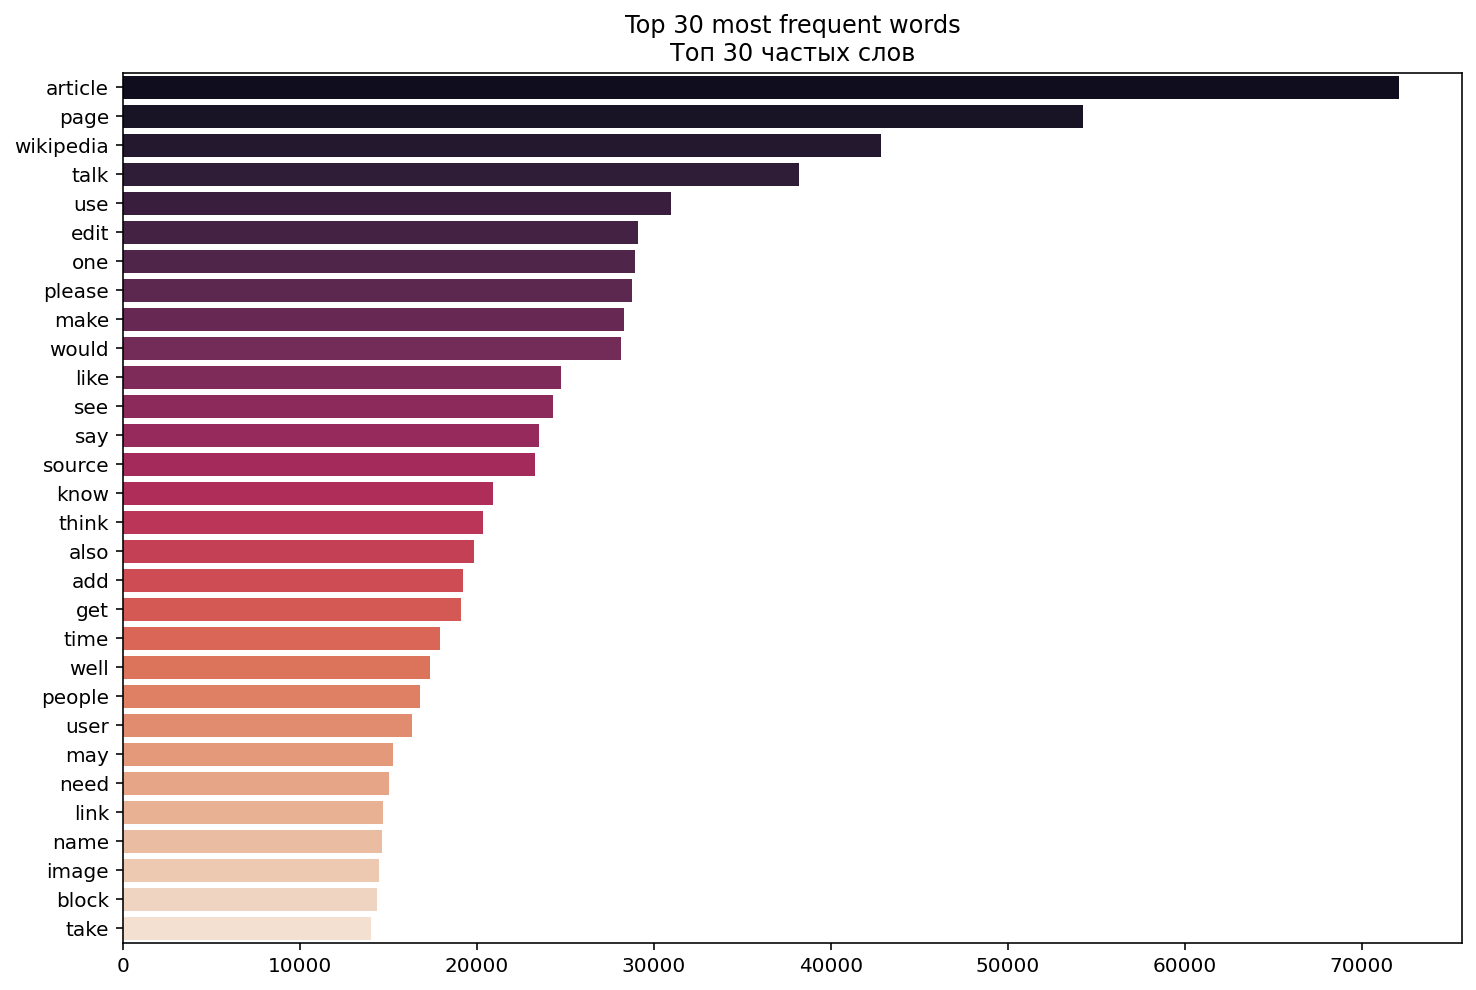

In [25]:
words_counter(list_non_toxic_full)

Normal words, no surprises.  
Let's take a look at the 30 most common words in toxic comments  

Нормальные слова, никаких неожиданностей.   
Посмотрим на 30 самых частых слов в токсичных комментариях

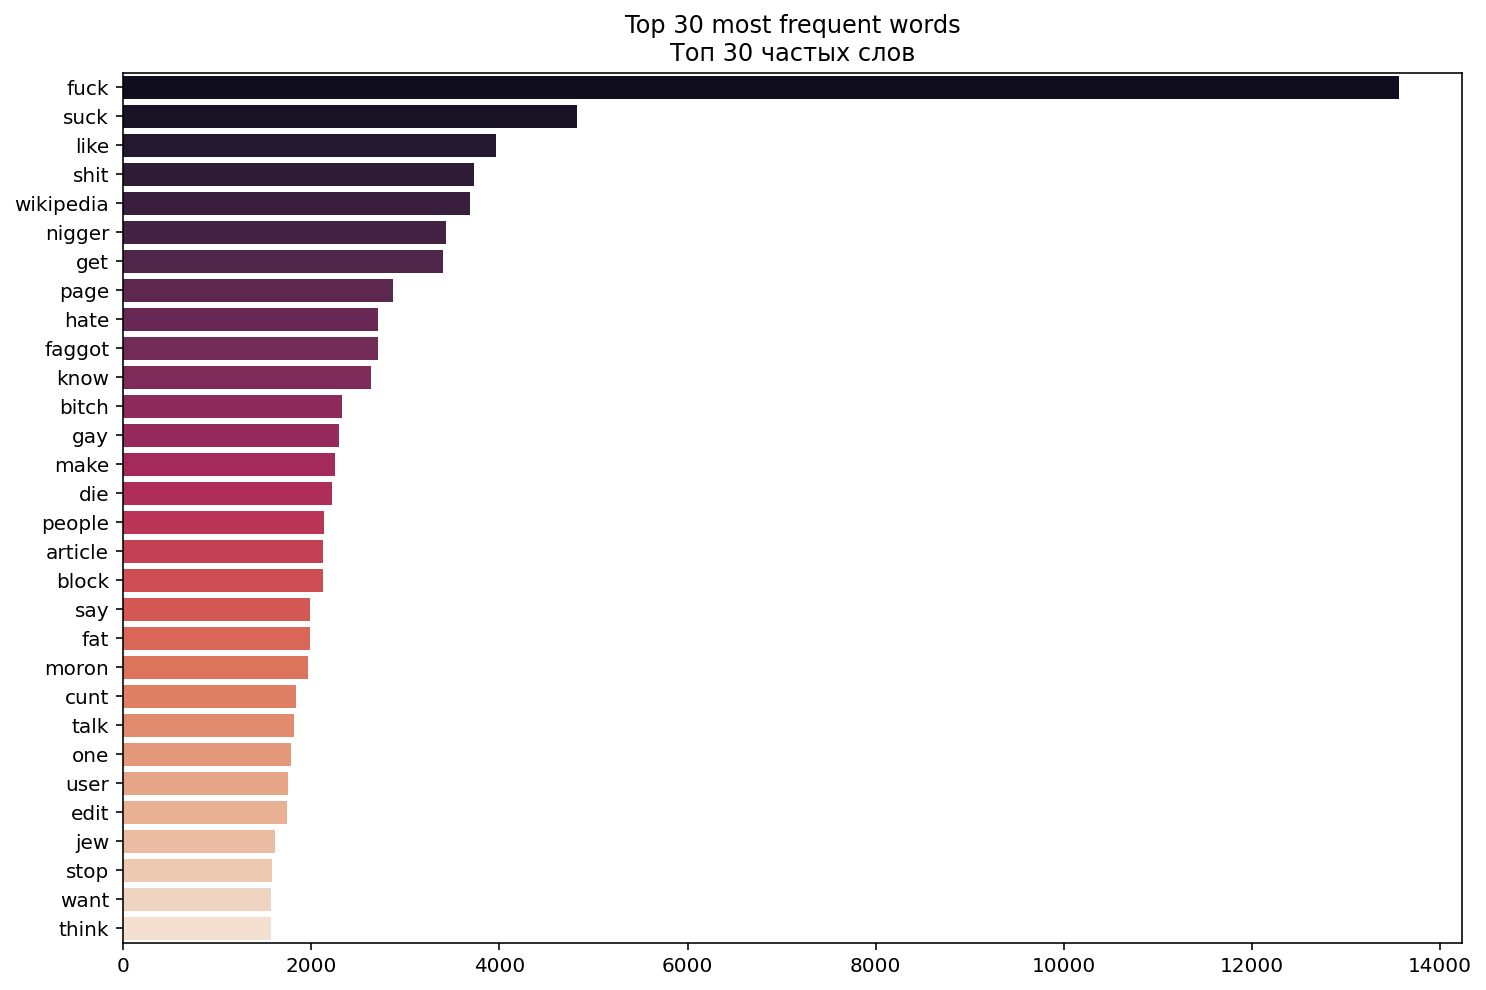

In [26]:
words_counter(list_toxic_full)

In addition to obscene words, there are many words that are also in the top 30 for normal comments. Let's remove the words that occur in normal comments from this list and see what happens.  
Кроме нецензурных слов встречается много слов, которые есть также в топ-30 для нормальных комментариев. Удалим слова, встречающиеся в нормальных комментариях из этого списка и посмотрим, что получится.

In [27]:
list_only_toxic = []
list_non_toxic_full_set = set(list_non_toxic_full)
for x in notebook.tqdm(data[data["toxic"] == 1]["clean_text"]):
    for i in x.split():
        if i not in list_non_toxic_full_set:
            list_only_toxic.append(i)

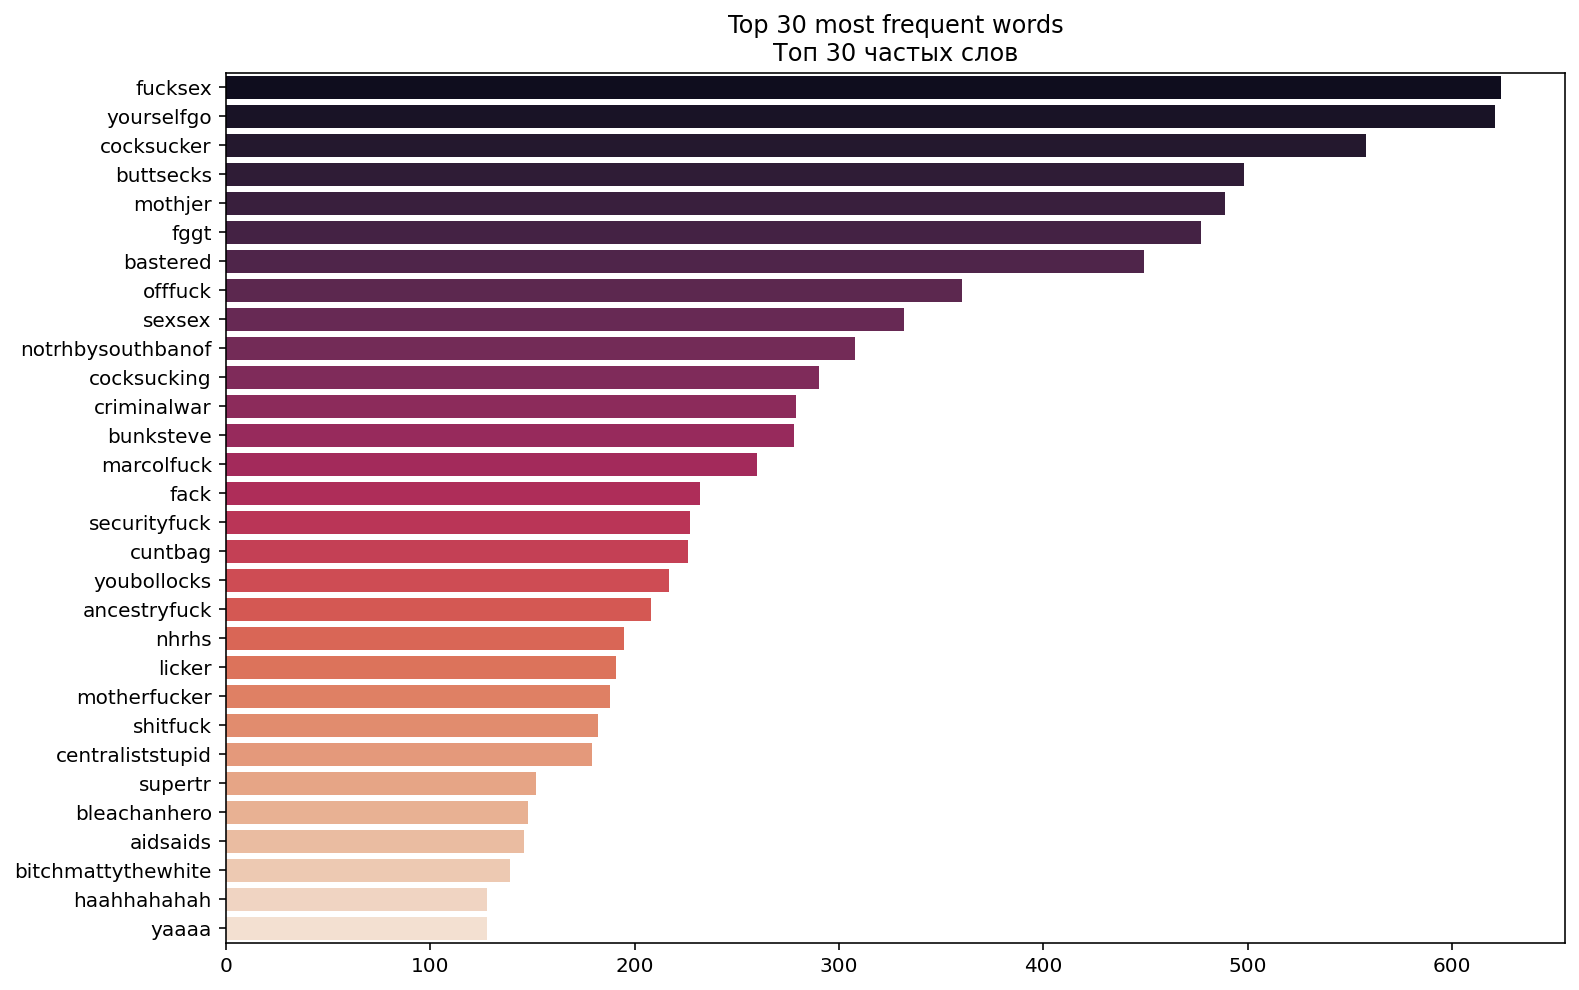

In [28]:
words_counter(list_only_toxic)

Some of the words such as' fuck',' suck',' shit',' nigger',' bitch ' disappeared from this list, that is, in the comments marked as non-toxic, there are also obscene and incorrect words. A question for those who marked up the data, what they were guided by and whether it is worth redoing the markup.

Otherwise, the top 30 contains obscene words and their combinations.  

Интересно, что часть слов, такие, как 'fuck', 'suck', 'shit', 'niger', 'bitch' исчезли из этого списка, то есть в комментариях, помеченных, как не токсичные, есть в том числе нецензурные и некорректные слова. Вопрос к тем, кто размечал данные, чем они руководствовались и не стоит ли переделать разметку.

В остальном же в топ-30 присутствуют нецензурные слова и их сочетания.

Example of comments marked as non-toxic containing the word 'fuck'  
Пример комментариев, помеченных, как не токсичные, содержащие слово 'fuck'

In [29]:
data[(data["clean_text"].str.contains("fuck")) & (data["toxic"] == 0)]["text"].sample(
    2
).to_list()

['User:Larrypooplinson \n\nHello. I noticed your indef-block notification at User talk:Larryfuckstylinson regarding a vandalism-only account and username policy violation. May I ask you to also have a look at User talk:Larrypooplinson? It seems to have the same issues and to be a probable sock. —',
 '"\nWell, why didn\'t you point this out in the first place instead of acting like a nutcase and telling me I\'m ""censoring"" things? Stop acting as if you own the article. Your bully tactics don\'t really work on wikipedia and certainly not with me. Please refrain from deleting good faith edits and labelling them as ""vandalism"". One more thing, please fucking read the policies before you jump into bed with them, okay? Then fuck off and implement them. I really don\'t have time wasting my efforts on slime-of-an-editor like you who always acts as a troll and misuses his tools..  Talk Contribs "']

There are clearly errors in the comments markup.  
В разметке комментариев явно присутствуют ошибки.

<a id='2'></a>

# 2. Обучение / Train

## Preparation / Подготовка

A function that accepts input:
- dataset,
- comment column for vectorization,
- the size of the training sample (validation and test samples of the same size),
- the name of the class for creating vectors,
- the number of words in the n-gram,
- whether downsampling is necessary (by default, it is not necessary).

The division into samples takes into account the imbalance of classes with the "stratify" parameter, there is no deletion of stop words during vectorization, since we have already deleted them.  
Returns tuples from the training, validation, and test sample (train_x, train_y), (valid_x, valid_y), (test_x, test_y)  

Функция, которая принимает на вход:
 - датасет, 
 - столбец комментариев для векторизации,
 - размер обучающей выборки (валидационная и тестовая одинакового размера),
 - название класса для создания векторов,
 - количество слов в n-грамме, 
 - нужно ли проводить даунсемплинг (по умолчанию - не нужно).
 
Разбиение на выборки идет с учетом дисбаланса классов с параметром "stratify", при векторизации нет удаления стоп-слов, так как мы их уже удалили.
 
Возвращает кортежи из обучающей, валидационной и тестовой выборки (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [30]:
def split_data(data, column, train_size, vectorizer, ngram_range, downsample=False):
    target = data["toxic"]
    features = data[column]
    train_x, test_valid_x, train_y, test_valid_y = train_test_split(
        features, target, train_size=train_size, random_state=12345, stratify=target
    )
    valid_x, test_x, valid_y, test_y = train_test_split(
        test_valid_x,
        test_valid_y,
        train_size=0.5,
        random_state=12345,
        stratify=test_valid_y,
    )
    if downsample == True:
        features_zeros = train_x[train_y == 0]
        features_ones = train_x[train_y == 1]
        target_zeros = train_y[train_y == 0]
        target_ones = train_y[train_y == 1]

        features_downsampled = pd.concat(
            [features_zeros.sample(features_ones.shape[0], random_state=12345)]
            + [features_ones]
        )
        target_downsampled = pd.concat(
            [target_zeros.sample(features_ones.shape[0], random_state=12345)]
            + [target_ones]
        )

        train_x, train_y = shuffle(
            features_downsampled, target_downsampled, random_state=12345
        )
    corpus_train = train_x.values.astype("U")
    corpus_valid = valid_x.values.astype("U")
    corpus_test = test_x.values.astype("U")
    if vectorizer == CountVectorizer:
        count_vect = CountVectorizer(ngram_range=ngram_range)
        count_vect.fit(corpus_train)
        train_x = count_vect.transform(corpus_train)
        valid_x = count_vect.transform(corpus_valid)
        test_x = count_vect.transform(corpus_test)
    elif vectorizer == TfidfVectorizer:
        tf_idf_vectorizer = TfidfVectorizer(ngram_range=ngram_range)
        tf_idf_vectorizer.fit(corpus_train)
        train_x = tf_idf_vectorizer.transform(corpus_train)
        valid_x = tf_idf_vectorizer.transform(corpus_valid)
        test_x = tf_idf_vectorizer.transform(corpus_test)
    else:
        train_x = corpus_train
        valid_x = corpus_valid
        test_x = corpus_test
    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

Function for filling the table with the results of models on the validation sample   
Функция для заполнения таблицы результатами моделей на валидационной выборке

In [31]:
summary = pd.DataFrame()


def fill_summary(x, y, model, model_name, vectorizer, n_gramms):
    try:
        prediction = model.best_estimator_.predict(x)
        probabilities = model.best_estimator_.predict_proba(x)
    except:
        prediction = model.predict(x)
        probabilities = model.predict_proba(x)
    summary.loc["vectorizer", model_name] = vectorizer
    summary.loc["vectorizer_range", model_name] = n_gramms
    try:
        summary.loc["f1_cross_val", model_name] = model.best_score_
    except:
        summary.loc["f1_cross_val", model_name] = np.nan
    summary.loc["f1_valid", model_name] = f1_score(y, prediction)
    summary.loc["accuracy_valid", model_name] = accuracy_score(y, prediction)
    summary.loc["recall_valid", model_name] = recall_score(y, prediction)
    summary.loc["precision_valid", model_name] = precision_score(y, prediction)
    summary.loc["roc_auc_valid", model_name] = roc_auc_score(y, probabilities[:, 1])
    return summary

The plotting function for Confusion matrix  
Функция построения графика Confusion matrix

In [32]:
def conf_matrix(x, y, model):
    class_names = ["not toxic", "toxic"]
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    disp = plot_confusion_matrix(
        model,
        x,
        y,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize="true",
        ax=ax,
    )
    disp.ax_.set_title("Normalized confusion matrix")
    plt.show()
    print('"Confusion matrix, without normalization\n')
    print(confusion_matrix(y, model.predict(x)), "\n")
    print("Classification report\n")
    print(classification_report(y, model.predict(x)))

Plotting Precision-Recall and ROC curve graphs, if conf_matrix=True, then also draws Confusion matrix  
Построение графиков Precision-Recall и ROC-кривой, если conf_matrix=True, то также рисует Confusion matrix

In [33]:
def precision_recall(x, y, model, confusion_matrix=True):
    probabilities = model.predict_proba(x)
    precision, recall, thresholds = precision_recall_curve(y, probabilities[:, 1])
    fpr, tpr, thresholds = roc_curve(y, probabilities[:, 1])
    auc = roc_auc_score(y, probabilities[:, 1])
    plt.figure(figsize=(15, 6))
    plt.subplot(121)
    plt.plot(fpr, tpr, label="roc-auc = {:.3f}".format(auc))
    plt.legend(loc="lower right")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-curve")
    plt.subplot(122)
    plt.step(recall, precision, where="post")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title("Precision-Recall")
    plt.show()
    if confusion_matrix:
        conf_matrix(x, y, model)

<a id='22'></a>

## Getting split data / Получение выборок

### train_test_split with CountVectorizer / Выборки с CountVectorizer

We get samples with the 'clean_text_without_http' column processed using CountVectorizer (), the size of the training sample is 0.8, ngram_range=(1,1)  
Получим выборки с обработанным с помощью CountVectorizer() столбцом 'clean_text_without_http', размером обучающей выборки - 0.8, ngram_range=(1,1)

In [34]:
train_bow, valid_bow, test_bow = split_data(
    data, "clean_text", 0.8, CountVectorizer, (1, 1)
)

In [35]:
train_bow[0].shape, train_bow[1].shape
valid_bow[0].shape, valid_bow[1].shape
test_bow[0].shape, test_bow[1].shape

((127573, 128241), (127573,))

((15947, 128241), (15947,))

((15947, 128241), (15947,))

### train_test_split with TfidfVectorizer / Выборки с  TfidfVectorizer

Samples with the 'clean_text_without_http' column processed using TfidfVectorizer (), the training sample size is 0.8, ngram_range=(1.1)  
Выборки с обработанным с помощью TfidfVectorizer() столбцом 'clean_text_without_http', размером обучающей выборки - 0.8, ngram_range=(1,1)

In [36]:
train_tfidf, valid_tfidf, test_tfidf = split_data(
    data, "clean_text", 0.8, TfidfVectorizer, (1, 1)
)

In [37]:
train_tfidf[0].shape, train_tfidf[1].shape
valid_tfidf[0].shape, valid_tfidf[1].shape
test_tfidf[0].shape, test_tfidf[1].shape

((127573, 128241), (127573,))

((15947, 128241), (15947,))

((15947, 128241), (15947,))

### train_test_split with CountVectorizer and downsample / Выборки с CountVectorizer и downsample

downsample / Выборки с даунсемплингом

In [38]:
train_bow_down, valid_bow_down, test_bow_down = split_data(
    data, "clean_text", 0.8, CountVectorizer, (1, 1), downsample=True
)

In [39]:
train_bow_down[0].shape, train_bow_down[1].shape
valid_bow_down[0].shape, valid_bow_down[1].shape
test_bow_down[0].shape, test_bow_down[1].shape

((25950, 44805), (25950,))

((15947, 44805), (15947,))

((15947, 44805), (15947,))

<a id='13'></a>

## LogisticRegression

### LogisticRegression (CountVectorizer)

Logistic regression with CountVectorizer, in GridSearchCV here and further left the minimum of optimal parameters obtained by iterating over a wider range of values.  

Логистическая регрессия с CountVectorizer, в GridSearchCV тут и дальше оставила минимум оптимальных параметров, полученных при  переборе более широкого диапазона значений.

In [40]:
params = {
    "solver": ["lbfgs", "liblinear"],
    #               'C': [.75, 1, 10],
    #               'max_iter':[100, 200, 500]
}

LR_count_vect = GridSearchCV(
    LogisticRegression(class_weight="balanced", random_state=17, max_iter=200),
    param_grid=params,
    #                              return_train_score=True,
    cv=4,
    n_jobs=6,
    verbose=1,
    scoring="f1",
)
LR_count_vect.fit(train_bow[0], train_bow[1])
LR_count_vect.best_score_
LR_count_vect.best_params_

Fitting 4 folds for each of 2 candidates, totalling 8 fits


GridSearchCV(cv=4,
             estimator=LogisticRegression(class_weight='balanced', max_iter=200,
                                          random_state=17),
             n_jobs=6, param_grid={'solver': ['lbfgs', 'liblinear']},
             scoring='f1', verbose=1)

0.7507773070659146

{'solver': 'lbfgs'}

In [41]:
fill_summary(
    valid_bow[0], valid_bow[1], LR_count_vect, "LR_count_vect", "CountVectorizer", 1
)

,LR_count_vect
vectorizer,CountVectorizer
vectorizer_range,1
f1_cross_val,0.750777
f1_valid,0.753794
accuracy_valid,0.945068
recall_valid,0.826757
precision_valid,0.692665
roc_auc_valid,0.9497


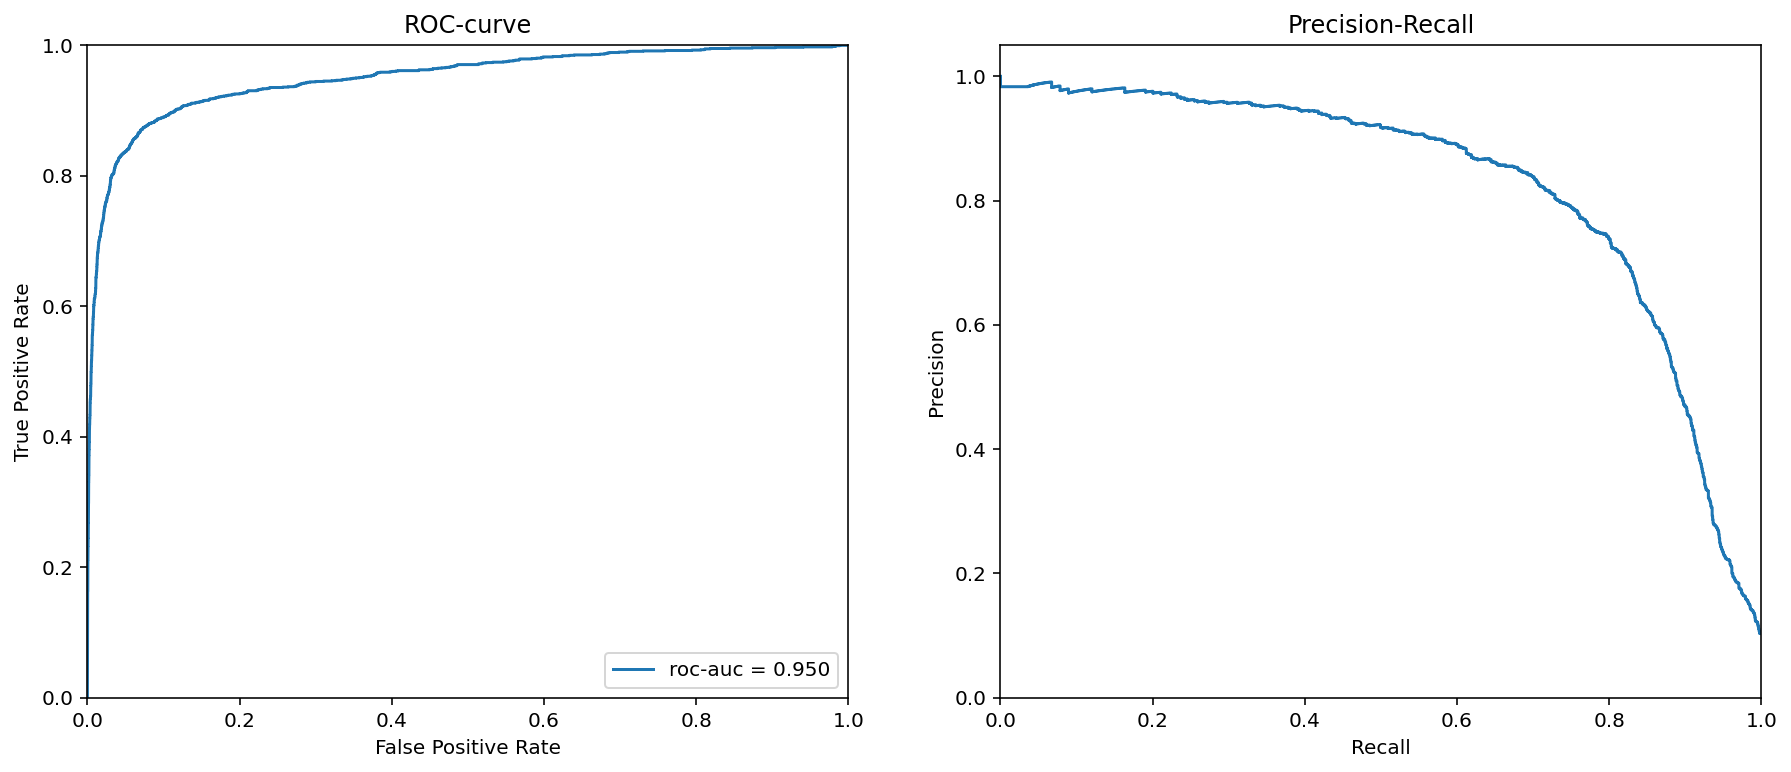

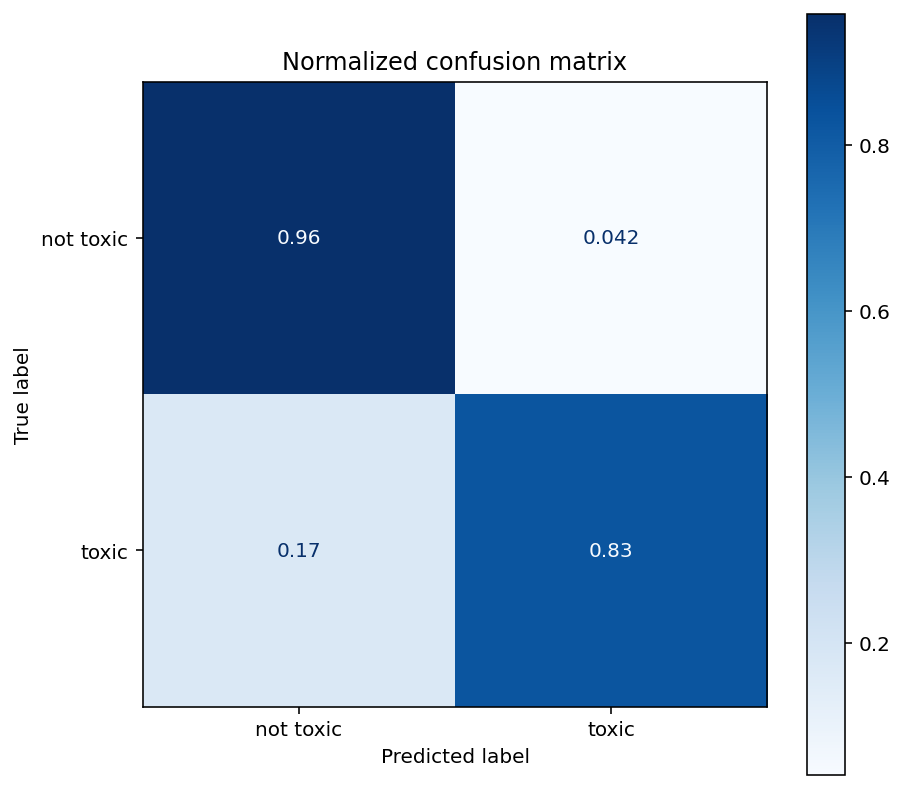

"Confusion matrix, without normalization

[[13730   595]
 [  281  1341]] 

Classification report

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     14325
           1       0.69      0.83      0.75      1622

    accuracy                           0.95     15947
   macro avg       0.84      0.89      0.86     15947
weighted avg       0.95      0.95      0.95     15947



In [42]:
precision_recall(valid_bow[0], valid_bow[1], LR_count_vect.best_estimator_)

On validation  with CountVectorizer, the logistic regression showed a good result, F1 = 0.757, accuracy=0.95, while recall is 0.826, that is, the model was able to correctly identify 82.6% of toxic comments from all toxic comments, 17.4% of toxic comments (281) were identified by the model as non-toxic. Of all the predicted toxic comments, 69% were correctly identified.  

The ROC curve shows that the model as a whole works much more efficiently than the random model (AUC of random model about 0.5), AUC = 0.95.  

Let's see if using TfidfVectorizer will improve the metrics.  

На валидационной выборке с CountVectorizer логистическая регрессия показала неплохой результат, F1 = 0.757, accuracy=0,95, при этом recall  0,826, то есть модель смогла правильно определить  82,6% токсичных комментариев из всех токсичных, 17,4% токсичных комментариев (281) модель определила как не токсичные. Из всех предсказанных токсичных комментариев правильно определены 69%.

ROC-кривая показывает, что модель в целом работает гораздо эффективней случайной модели, AUC = 0.95.

Посмотрим, не улучшит ли метрики использование TfidfVectorizer.

### LogisticRegression (TfidfVectorizer)

In [43]:
tf_idf_params = {
    "solver": ["lbfgs", "liblinear"],
    #         'C': [.25, .5, .75, 1]
}
LR_tf = LogisticRegression(class_weight="balanced", random_state=17)
LR_tf_idf = GridSearchCV(
    LR_tf, param_grid=tf_idf_params, cv=5, n_jobs=6, verbose=1, scoring="f1"
)
LR_tf_idf.fit(train_tfidf[0], train_tfidf[1])
LR_tf_idf.best_score_
LR_tf_idf.best_params_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=17),
             n_jobs=6, param_grid={'solver': ['lbfgs', 'liblinear']},
             scoring='f1', verbose=1)

0.7455330682132024

{'solver': 'liblinear'}

In [44]:
fill_summary(
    valid_tfidf[0], valid_tfidf[1], LR_tf_idf, "LR_tf_idf", "TfidfVectorizer", 1
)

,LR_count_vect,LR_tf_idf
vectorizer,CountVectorizer,TfidfVectorizer
vectorizer_range,1,1
f1_cross_val,0.750777,0.745533
f1_valid,0.753794,0.738911
accuracy_valid,0.945068,0.938358
recall_valid,0.826757,0.857583
precision_valid,0.692665,0.64909
roc_auc_valid,0.9497,0.970628


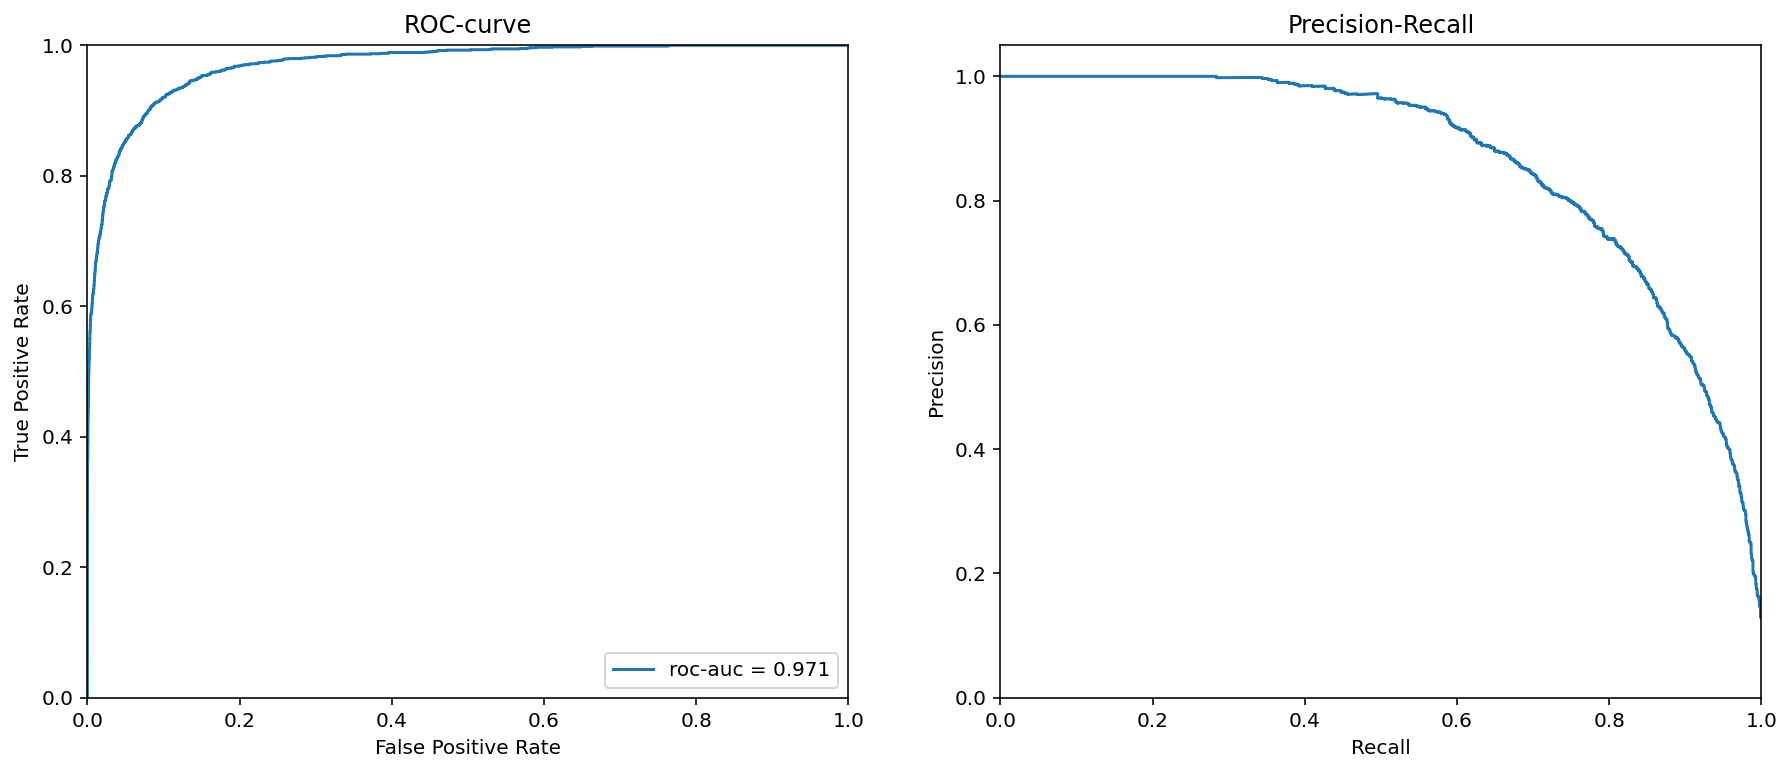

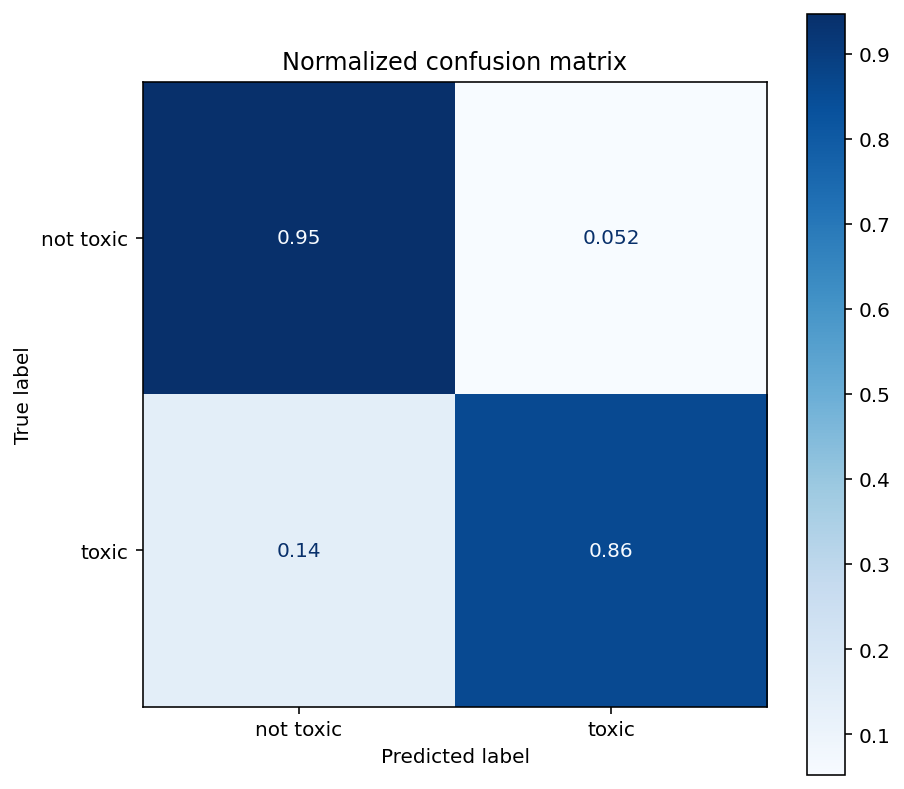

"Confusion matrix, without normalization

[[13573   752]
 [  231  1391]] 

Classification report

              precision    recall  f1-score   support

           0       0.98      0.95      0.97     14325
           1       0.65      0.86      0.74      1622

    accuracy                           0.94     15947
   macro avg       0.82      0.90      0.85     15947
weighted avg       0.95      0.94      0.94     15947



In [45]:
precision_recall(valid_tfidf[0], valid_tfidf[1], LR_tf_idf.best_estimator_)

The results of the logistic regression with the samples obtained using TfidfVectorizer are slightly worse on the validation of F1 = 0.739, accuracy=0.94 and recall = 0.86, that is, the model was able to correctly identify 86% of the toxic comments from all the toxic ones. Of all the predicted toxic comments, 70% are correctly predicted.  

In this case, I think that a higher recall value is more important, since toxic comments that do not get moderated can alienate potential buyers and the loss may be higher than from moderation of additional comments that the model has identified as toxic.  

The ROC curve shows that the model as a whole works much more efficiently than the random model, AUC = 0.973, the precision_recall curve is more convex, without a step, as in the model on samples with CountVectorizer.  

Результаты логистической регрессии с выборками, полученными с помощью TfidfVectorizer чуть хуже, на валидации F1 = 0.739, accuracy=0,94 и recall = 0,86, то есть модель смогла правильно определить 86% токсичных комментариев из всех токсичных. Из всех предсказанных токсичных комментариев правильно предсказаны 70%.

В данном случае, я считаю, что важнее более высокое значение recall, так как токсичные комментарии, не попавшие на модерацию, могут оттолкнуть потенциальных покупателей и убыток может быть выше, чем от модерации дополнительных комментариев, которые модель определила как токсичные.

ROC-кривая показывает, что модель в целом работает гораздо эффективней случайной модели, AUC = 0.973, кривая precision_recall более выпуклая, без ступеньки, как у модели на выборках с CountVectorizer.

### LogisticRegression (CountVectorizer & downsample)

In [46]:
params = {
    "solver": ["lbfgs", "liblinear"],
}
LR_d = LogisticRegression(class_weight="balanced", random_state=17)
LR_count_vect_down = GridSearchCV(
    LR_d, param_grid=params, cv=5, n_jobs=-1, verbose=1, scoring="f1"
)
LR_count_vect_down.fit(train_bow_down[0], train_bow_down[1])
LR_count_vect_down.best_score_
LR_count_vect_down.best_params_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=17),
             n_jobs=-1, param_grid={'solver': ['lbfgs', 'liblinear']},
             scoring='f1', verbose=1)

0.8929474566305299

{'solver': 'lbfgs'}

In [47]:
fill_summary(
    valid_bow_down[0],
    valid_bow_down[1],
    LR_count_vect_down,
    "LR_count_vect_down",
    "CountVectorizer",
    1,
)

,LR_count_vect,LR_tf_idf,LR_count_vect_down
vectorizer,CountVectorizer,TfidfVectorizer,CountVectorizer
vectorizer_range,1,1,1
f1_cross_val,0.750777,0.745533,0.892947
f1_valid,0.753794,0.738911,0.685372
accuracy_valid,0.945068,0.938358,0.917727
recall_valid,0.826757,0.857583,0.881011
precision_valid,0.692665,0.64909,0.560832
roc_auc_valid,0.9497,0.970628,0.955529


In this case, the results of the logistic regression are worse, F1 on cross-validation is 0.89, on validation F1 = 0.68, the model retrained, accuracy=0.92, but recall = 0.88, that is, the model was able to correctly identify 88% of the toxic comments from all the toxic ones. precision is only 0.56, that is, 44% of the comments that the model classified as toxic are not. AUC = 0.95.  

В данном случае результаты логистической регрессии хуже, F1 на кросс-валидации 0,89, на валидации F1 = 0.68, модель переобучилась, accuracy=0,92, но при этом recall = 0,88, то есть модель смогла правильно определить 88% токсичных комментариев из всех токсичных. precision всего 0,56, то есть 44% комментариев, которые модель отнесла к токсичным, ими не являются. AUC = 0.95.

<a id='14'></a>

### RandomForestClassifier (CountVectorizer)

The results of the random forest on the full dataset were much worse than the logistic regression, plus the selection of parameters took too much time. Therefore, I give a table with the results obtained, and here I leave the code for a random forest on a training sample with downsampling.  

Результаты случайного леса на полном датасете оказались гораздо хуже логистической регресии, плюс подбор параметров занимал слишком много времени. Поэтому превожу таблицу с получившимися результатами, а тут оставляю код для случайного леса на обучающей выборке с даунсемплингом.

In [48]:
summary_first = pd.read_csv(
    "https://raw.githubusercontent.com/ntatanko/sprint_ML_texts/main/summary.csv",
    index_col=[0],
)
summary[["forest_count_vect", "forest_tfidf"]] = summary_first[
    ["forest_count_vect", "forest_tfidf"]
]
summary_first[["forest_count_vect", "forest_tfidf"]]

,forest_count_vect,forest_tfidf
vectorizer,CountVectorizer,TfidfVectorizer
vectorizer_range,1,1
f1_cross_val,0.5956110737435862,0.5956427661134428
f1_valid,0.6041070964387835,0.604384133611691
accuracy_valid,0.9363453983114604,0.9366379670651175
recall_valid,0.4774034511092851,0.47576006573541496
precision_valid,0.8223637650389243,0.8283261802575107
roc_auc_valid,0.9521097624982393,0.9552605211608423


In [49]:
param_forest = {"n_estimators": range(200, 250, 50), "max_depth": range(300, 310, 10)}
forest_cv = RandomForestClassifier(random_state=17, class_weight="balanced")
forest_count_vect = GridSearchCV(
    forest_cv, cv=4, n_jobs=-1, verbose=1, param_grid=param_forest, scoring="f1"
)
forest_count_vect.fit(train_bow_down[0], train_bow_down[1])
forest_count_vect.best_score_
forest_count_vect.best_params_

Fitting 4 folds for each of 1 candidates, totalling 4 fits


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(300, 310, 10),
                         'n_estimators': range(200, 250, 50)},
             scoring='f1', verbose=1)

0.8552253827969157

{'max_depth': 300, 'n_estimators': 200}

In [50]:
fill_summary(
    valid_bow_down[0],
    valid_bow_down[1],
    forest_count_vect,
    "forest_count_vect_down",
    "CountVectorizer",
    1,
)

,LR_count_vect,LR_tf_idf,LR_count_vect_down,forest_count_vect,forest_tfidf,forest_count_vect_down
vectorizer,CountVectorizer,TfidfVectorizer,CountVectorizer,CountVectorizer,TfidfVectorizer,CountVectorizer
vectorizer_range,1,1,1,1,1,1
f1_cross_val,0.750777,0.745533,0.892947,0.5956110737435862,0.5956427661134428,0.855225
f1_valid,0.753794,0.738911,0.685372,0.6041070964387835,0.604384133611691,0.672489
accuracy_valid,0.945068,0.938358,0.917727,0.9363453983114604,0.9366379670651175,0.920048
recall_valid,0.826757,0.857583,0.881011,0.4774034511092851,0.47576006573541496,0.807028
precision_valid,0.692665,0.64909,0.560832,0.8223637650389243,0.8283261802575107,0.576398
roc_auc_valid,0.9497,0.970628,0.955529,0.9521097624982393,0.9552605211608423,0.948126


 The results of the random forest are worse than the results of the logistic regression, the model is overfitted, f1-score=0.85 on the cross-validation, on the validation sample f1-score=0.67, accuracy=0.92, recall=0.81. 
 
 Результаты случайного леса хуже результатов логистической регрессии, модель сильно переобучилась, f1-score=0,85 на кросс-валидации, на валидационной выборке f1-score=0,67, accuracy=0.92, recall=0.81.

<a id='15'></a>

<a id='16'></a>

## LGBMClassifier

### LGBMClassifier (CountVectorizer)

In [51]:
param_lgbm = {
    "n_estimators": range(200, 250, 50),
    "num_leaves": range(500, 510, 10),
    "min_data_in_leaf": range(15, 20, 5),
    #     'learning_rate': (0.1, 0.01)
}
lgbm_count_vect = GridSearchCV(
    lgb.LGBMClassifier(
        random_state=17, class_weight="balanced", subsample_for_bin=5000
    ),
    cv=4,
    n_jobs=-1,
    verbose=1,
    param_grid=param_lgbm,
    scoring="f1",
)
lgbm_count_vect.fit(train_bow[0].astype("float"), train_bow[1])
lgbm_count_vect.best_score_
lgbm_count_vect.best_params_

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


GridSearchCV(cv=4,
             estimator=LGBMClassifier(class_weight='balanced', random_state=17,
                                      subsample_for_bin=5000),
             n_jobs=-1,
             param_grid={'min_data_in_leaf': range(15, 20, 5),
                         'n_estimators': range(200, 250, 50),
                         'num_leaves': range(500, 510, 10)},
             scoring='f1', verbose=1)

0.7739702373663795

{'min_data_in_leaf': 15, 'n_estimators': 200, 'num_leaves': 500}

In [52]:
fill_summary(
    valid_bow[0].astype("float"),
    valid_bow[1],
    lgbm_count_vect,
    "lgbm_count_vect",
    "CountVectorizer",
    1,
)

,LR_count_vect,LR_tf_idf,LR_count_vect_down,forest_count_vect,forest_tfidf,forest_count_vect_down,lgbm_count_vect
vectorizer,CountVectorizer,TfidfVectorizer,CountVectorizer,CountVectorizer,TfidfVectorizer,CountVectorizer,CountVectorizer
vectorizer_range,1,1,1,1,1,1,1
f1_cross_val,0.750777,0.745533,0.892947,0.5956110737435862,0.5956427661134428,0.855225,0.77397
f1_valid,0.753794,0.738911,0.685372,0.6041070964387835,0.604384133611691,0.672489,0.770482
accuracy_valid,0.945068,0.938358,0.917727,0.9363453983114604,0.9366379670651175,0.920048,0.953973
recall_valid,0.826757,0.857583,0.881011,0.4774034511092851,0.47576006573541496,0.807028,0.759556
precision_valid,0.692665,0.64909,0.560832,0.8223637650389243,0.8283261802575107,0.576398,0.781726
roc_auc_valid,0.9497,0.970628,0.955529,0.9521097624982393,0.9552605211608423,0.948126,0.958738


f1-score on both the cross-validation and validation sample is 0.77, the precision and recall are very close in value (0.78 and 0.76). Let's see how LGBMClassifier works with TTfidfVectorizer.  
f1-score и на кросс-валидации и на валидационной выборке 0,77, точность и полнота очень болизки по значению (0,78 и 0,76). Посмотрим, как LGBMClassifier отработает с TTfidfVectorizer.

### LGBMClassifier (TTfidfVectorizer)

In [53]:
param_lgbm = {
    "n_estimators": range(200, 250, 50),
    "num_leaves": range(500, 510, 10),
    "min_data_in_leaf": (8, 10),
}
lgbm_tfidf = GridSearchCV(
    lgb.LGBMClassifier(
        random_state=17, class_weight="balanced", subsample_for_bin=10000
    ),
    cv=3,
    n_jobs=-1,
    verbose=1,
    param_grid=param_lgbm,
    scoring="f1",
)
lgbm_tfidf.fit(train_tfidf[0], train_tfidf[1])
lgbm_tfidf.best_score_
lgbm_tfidf.best_params_

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


GridSearchCV(cv=3,
             estimator=LGBMClassifier(class_weight='balanced', random_state=17,
                                      subsample_for_bin=10000),
             n_jobs=-1,
             param_grid={'min_data_in_leaf': (8, 10),
                         'n_estimators': range(200, 250, 50),
                         'num_leaves': range(500, 510, 10)},
             scoring='f1', verbose=1)

0.7708024517865321

{'min_data_in_leaf': 8, 'n_estimators': 200, 'num_leaves': 500}

In [54]:
fill_summary(
    valid_tfidf[0], valid_tfidf[1], lgbm_tfidf, "lgbm_tfidf", "TfidfVectorizer", 1
)

,LR_count_vect,LR_tf_idf,LR_count_vect_down,forest_count_vect,forest_tfidf,forest_count_vect_down,lgbm_count_vect,lgbm_tfidf
vectorizer,CountVectorizer,TfidfVectorizer,CountVectorizer,CountVectorizer,TfidfVectorizer,CountVectorizer,CountVectorizer,TfidfVectorizer
vectorizer_range,1,1,1,1,1,1,1,1
f1_cross_val,0.750777,0.745533,0.892947,0.5956110737435862,0.5956427661134428,0.855225,0.77397,0.770802
f1_valid,0.753794,0.738911,0.685372,0.6041070964387835,0.604384133611691,0.672489,0.770482,0.774522
accuracy_valid,0.945068,0.938358,0.917727,0.9363453983114604,0.9366379670651175,0.920048,0.953973,0.955603
recall_valid,0.826757,0.857583,0.881011,0.4774034511092851,0.47576006573541496,0.807028,0.759556,0.749692
precision_valid,0.692665,0.64909,0.560832,0.8223637650389243,0.8283261802575107,0.576398,0.781726,0.801054
roc_auc_valid,0.9497,0.970628,0.955529,0.9521097624982393,0.9552605211608423,0.948126,0.958738,0.961707


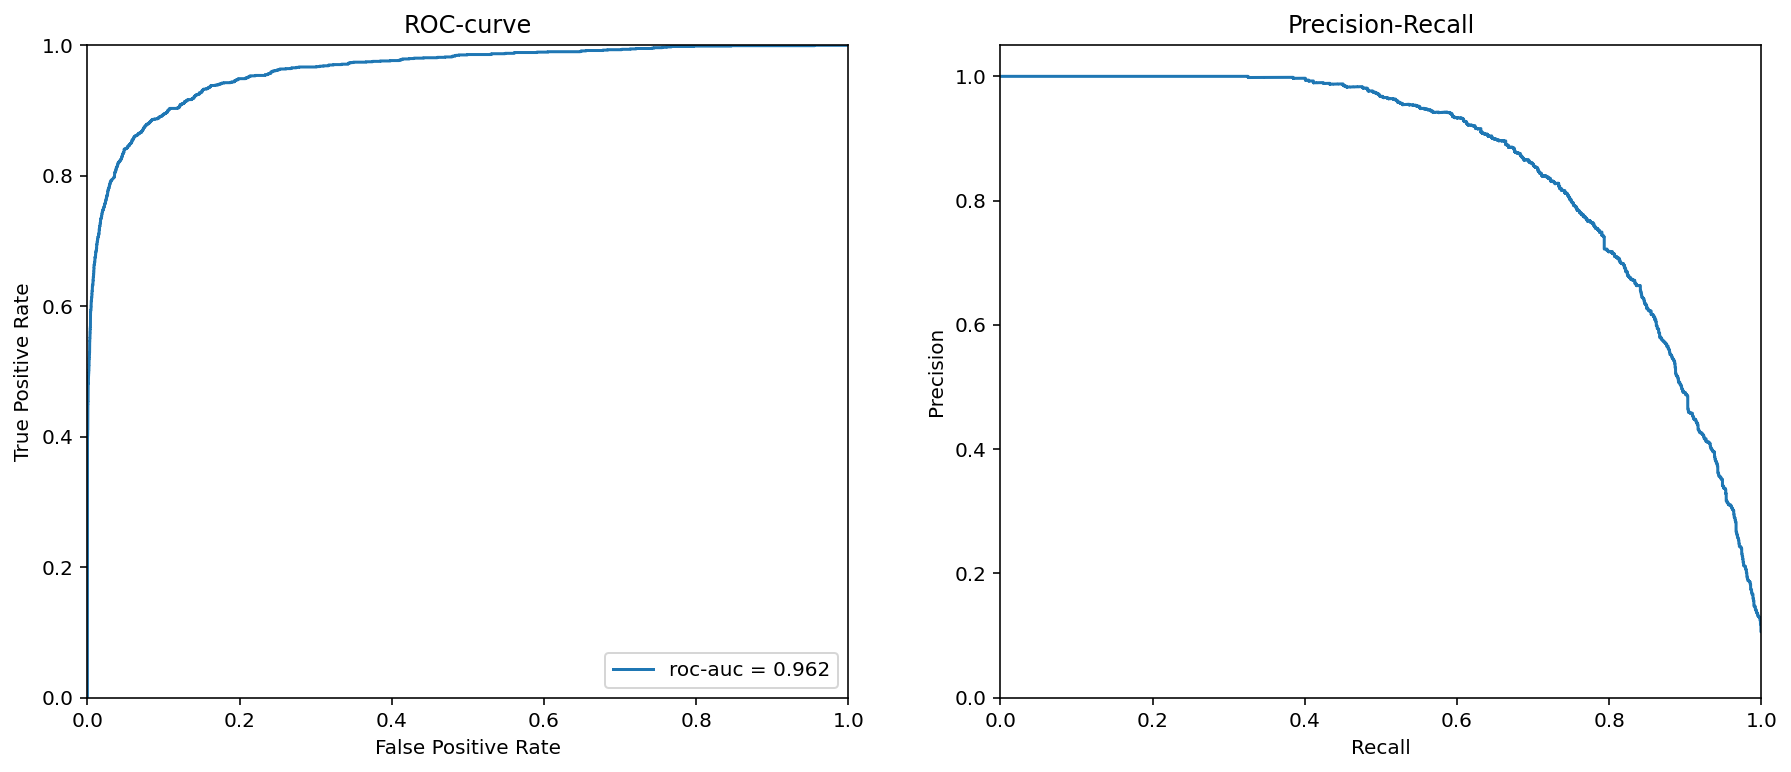

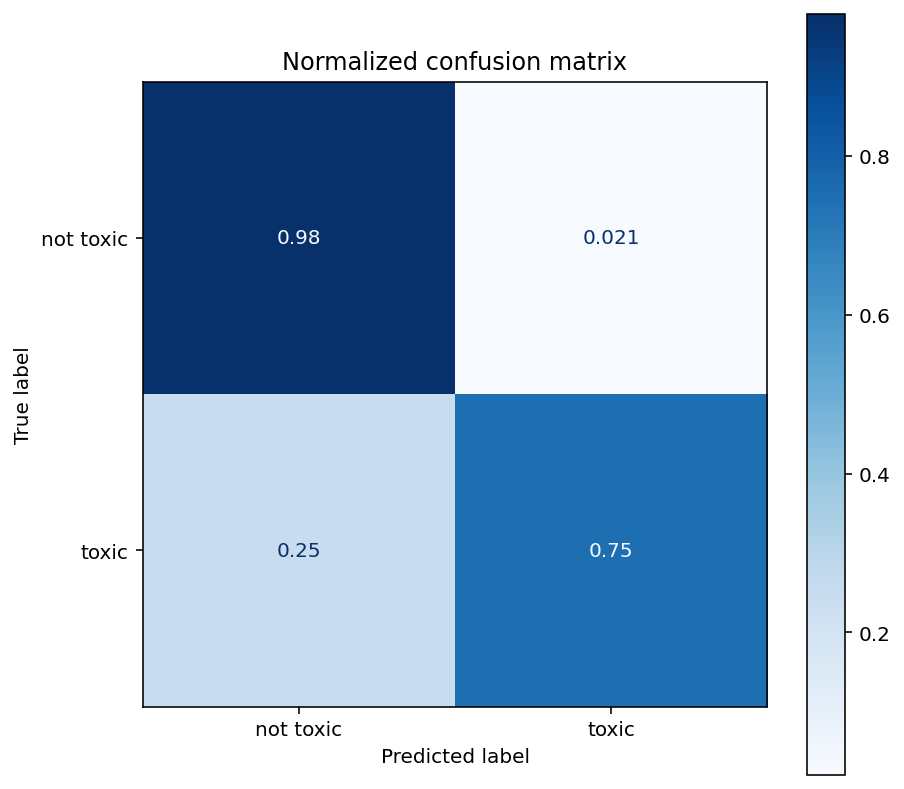

"Confusion matrix, without normalization

[[14023   302]
 [  406  1216]] 

Classification report

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     14325
           1       0.80      0.75      0.77      1622

    accuracy                           0.96     15947
   macro avg       0.89      0.86      0.87     15947
weighted avg       0.95      0.96      0.95     15947



In [55]:
precision_recall(valid_tfidf[0], valid_tfidf[1], lgbm_tfidf.best_estimator_)

f1-score is also 0.77, but the recall has decreased to 0.75, and the precision has increased to 0.80.  
f1-score тоже 0,77, но при этом уменьшилась полнота до 0,75, а точность увеличилась до 0,80.

<a id='17'></a>

## LogisticRegression (ngram_range = (2, 2)

Let's try to train a logistic regression with bigrams.  
Попробуем обучить логистическую регрессию с биграммами.

In [56]:
train_bow2, valid_bow2, test_bow2 = split_data(
    data.sample(20000, random_state=17), "clean_text", 0.7, CountVectorizer, (2, 2)
)

In [57]:
train_bow2[0].shape, train_bow2[1].shape
valid_bow2[0].shape, valid_bow2[1].shape
test_bow2[0].shape, test_bow2[1].shape

((14000, 306006), (14000,))

((3000, 306006), (3000,))

((3000, 306006), (3000,))

In [58]:
params = {
    "solver": ["lbfgs", "liblinear"],
}
lr_count_vec_2 = GridSearchCV(
    LogisticRegression(class_weight="balanced", random_state=17),
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring="f1",
)
lr_count_vec_2.fit(train_bow2[0], train_bow2[1])
lr_count_vec_2.best_score_
lr_count_vec_2.best_params_

f1_score(valid_bow2[1], lr_count_vec_2.best_estimator_.predict(valid_bow2[0]))
f1_score(test_bow2[1], lr_count_vec_2.best_estimator_.predict(test_bow2[0]))

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=17),
             n_jobs=-1, param_grid={'solver': ['lbfgs', 'liblinear']},
             scoring='f1', verbose=1)

0.2571566000150912

{'solver': 'liblinear'}

0.2833333333333333

0.29729729729729726

In [59]:
fill_summary(
    valid_bow2[0], valid_bow2[1], lr_count_vec_2, "lr_count_vec_2", "CountVectorizer", 2
)

,LR_count_vect,LR_tf_idf,LR_count_vect_down,forest_count_vect,forest_tfidf,forest_count_vect_down,lgbm_count_vect,lgbm_tfidf,lr_count_vec_2
vectorizer,CountVectorizer,TfidfVectorizer,CountVectorizer,CountVectorizer,TfidfVectorizer,CountVectorizer,CountVectorizer,TfidfVectorizer,CountVectorizer
vectorizer_range,1,1,1,1,1,1,1,1,2
f1_cross_val,0.750777,0.745533,0.892947,0.5956110737435862,0.5956427661134428,0.855225,0.77397,0.770802,0.257157
f1_valid,0.753794,0.738911,0.685372,0.6041070964387835,0.604384133611691,0.672489,0.770482,0.774522,0.283333
accuracy_valid,0.945068,0.938358,0.917727,0.9363453983114604,0.9366379670651175,0.920048,0.953973,0.955603,0.914
recall_valid,0.826757,0.857583,0.881011,0.4774034511092851,0.47576006573541496,0.807028,0.759556,0.749692,0.174061
precision_valid,0.692665,0.64909,0.560832,0.8223637650389243,0.8283261802575107,0.576398,0.781726,0.801054,0.761194
roc_auc_valid,0.9497,0.970628,0.955529,0.9521097624982393,0.9552605211608423,0.948126,0.958738,0.961707,0.79895


The use of bigrams in this case showed a bad result, f1=0.28, and the result is a huge table that takes longer to process.
  
Использование словосочетаний из двух слов в данном случае показало плохой результат, f1=0.28, при этом получается таблица огромного размера, которая обрабатывеатся дольше.

<a id='3'></a>

## 3. Test / Проверка на тесте

Since LGBMClassifier showed the best results, let's look at its results on the test with CountVectorizer  

Поскольку LGBMClassifier показал лучшие результаты, то посмотрим на его результаты на тесте на выборках с CountVectorizer

In [60]:
print("Test f1-score")
f1_score(
    test_bow[1], lgbm_count_vect.best_estimator_.predict(test_bow[0].astype("float"))
)
print(
    classification_report(
        test_bow[1],
        lgbm_count_vect.best_estimator_.predict(test_bow[0].astype("float")),
    )
)

Test f1-score


0.7891242491305722

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     14325
           1       0.81      0.77      0.79      1622

    accuracy                           0.96     15947
   macro avg       0.89      0.87      0.88     15947
weighted avg       0.96      0.96      0.96     15947



f1 on test is 0.789, the goal is achieved, but recall is only 77%.  
Let's look at the results of the logistic regression on test.   

f1 на тестовой выборке 0,789, цель достигнута, но полнота всего 77%.   
Посмотрим на результаты логистической регрессиию на тестовой выборке.  

In [61]:
print("Test f1-score")
f1_score(test_bow[1], LR_count_vect.best_estimator_.predict(test_bow[0]))
print(
    classification_report(
        test_bow[1], LR_count_vect.best_estimator_.predict(test_bow[0])
    )
)

Test f1-score


0.7617705102903863

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     14325
           1       0.70      0.83      0.76      1622

    accuracy                           0.95     15947
   macro avg       0.84      0.90      0.87     15947
weighted avg       0.95      0.95      0.95     15947



f1-score is smaller, but recall is bigger.  
Since I think that recall is also important for this task, we will try to change the threshold and see how the main metrics change:  

f1-score меньше, но при этом больше полнота.
Поскольку я считаю, что данной задаче важен также recall, то попробуем изменить порог и посмотреть, как меняются основные метрики:

In [62]:
probabilities = LR_count_vect.best_estimator_.predict_proba(test_bow[0])
for threshold in np.arange(0, 0.51, 0.05):
    predicted_valid = probabilities[:, 1] > threshold
    precision = precision_score(test_bow[1], predicted_valid)
    recall = recall_score(test_bow[1], predicted_valid)
    accuracy = accuracy_score(test_bow[1], predicted_valid)
    f1 = f1_score(test_bow[1], predicted_valid)
    print(
        "threshold = {:.2f} | precision = {:.3f}, recall = {:.3f}, accuracy = {:.3f}, f1_score = {:.3f}".format(
            threshold, precision, recall, accuracy, f1
        )
    )

threshold = 0.00 | precision = 0.102, recall = 1.000, accuracy = 0.102, f1_score = 0.185
threshold = 0.05 | precision = 0.244, recall = 0.951, accuracy = 0.695, f1_score = 0.388
threshold = 0.10 | precision = 0.315, recall = 0.936, accuracy = 0.787, f1_score = 0.472
threshold = 0.15 | precision = 0.381, recall = 0.917, accuracy = 0.840, f1_score = 0.539
threshold = 0.20 | precision = 0.451, recall = 0.906, accuracy = 0.878, f1_score = 0.602
threshold = 0.25 | precision = 0.516, recall = 0.898, accuracy = 0.904, f1_score = 0.655
threshold = 0.30 | precision = 0.565, recall = 0.887, accuracy = 0.919, f1_score = 0.690
threshold = 0.35 | precision = 0.610, recall = 0.877, accuracy = 0.930, f1_score = 0.719
threshold = 0.40 | precision = 0.640, recall = 0.860, accuracy = 0.937, f1_score = 0.734
threshold = 0.45 | precision = 0.670, recall = 0.846, accuracy = 0.942, f1_score = 0.748
threshold = 0.50 | precision = 0.702, recall = 0.833, accuracy = 0.947, f1_score = 0.762


It may be worth sacrificing precision in favor of recall, for example, at the threshold of 0.25, the recall of the model is 0.898, while the precision is only 51.6%, f1_score = 0.65, so 88% of toxic comments will get to moderation, but almost the same number of normal comments will also be classified as toxic and will also get to moderation.  

Может быть стоит пожертвовать точностью в пользу полноты, например, при пороге в 0.25 полнота (recall) модели 0,898, при этом точность всего 51,6%, f1_score = 0.65, таким образом 88% токсичных комментариев попадут на модерацию, но почти столько же нормальных комментариев тоже будет отнесено к токсичным и тоже попадет на модерацию.

<a id='4'></a>

# 4. Conclusion / Выводы

 - the quality of data markup is in doubt, in comments that are flagged as non-toxic, there are obscene words, it is difficult to detect toxic comments in the training of the models,
 - on average toxic comments shorter and with fewer words then non-toxic ones, punctuation is also less on average, but the range of values is bigger.
 - the best results on training showed LGBMClassifier and logistic regression with CountVectorizer, f1 on test - of 0.79 and 0.76, respectively, the recall is 77% and 83%,
 - for this task, I think that  recall is very important - the proportion of correctly identified toxic comments out of all toxic ones, since missing toxic comments can alienate potential buyers and the potential loss can be much greater than the funds spent on additional moderation,
 - based on this, you can change the classification threshold to achieve a higher recall.  

- качество разметки данных вызывает сомнение, в комментариях, помеченных, как не токсичные, встречаются нецензурные слова и обсценная лексика, это затрудняет определение токсичных комментариев при обучении моделей,
 - в среднем токсичные комментарии короче и с меньшим количеством слов, чем не токсичные, знаков препинания тоже в среднем меньше, но разброс значений больше,
 - лучшие результаты на обучении показала модель LGBMClassifier и логистической регрессии с CountVectorizer, f1 на тестовой выборке - 0,79 и 0,76 соответсвенно, полнота 77% и 83%,
 - для данной задачи считаю важным параметр recall - доля правильно определенных токсичных комментариев из всех токсичных, так как пропущенные токсичные комментарии могут оттолкнуть потенциальных покупателей и потенциальный убыток может быть сильно болше, чем потраченные на дополнительную модерацию средства,
 - исходя из этого, можно менять порог классификации, добиваясь более бысокого значения полноты.